In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
import torch
import matplotlib.pyplot as plt
import pandas as pd
from bayes_traj.pyro_helper import *

torch.set_default_dtype(torch.double)

# Read toy data and plot

In [16]:
df = pd.read_csv('2d_gaussian_3_visits_std-0.05.csv')
preds = ['intercept', 'age']
targets = ['y1']

Color-code data based on ground-truth trajectory assignment ('traj_gt')

Text(0, 0.5, 'y1')

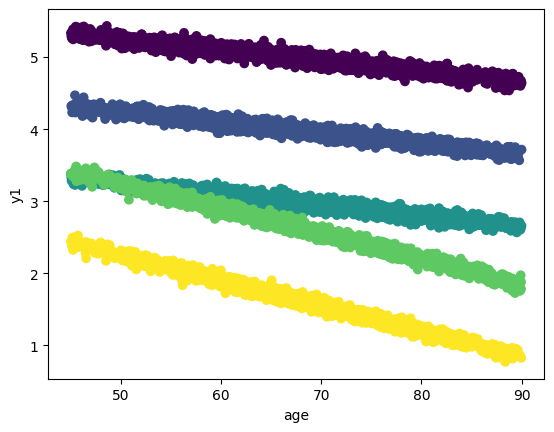

In [17]:
plt.scatter(df['age'], df['y1'], c=df['traj_gt'])
plt.xlabel('age')
plt.ylabel('y1')

# Fit to data

In [30]:
!bayes_traj_main --in_csv 2d_gaussian_3_visits_std-0.05.csv --targets y1 --groupby id --prior 2d_gaussians_3_visits_std-0.05_prior.p --verbose --iters 4000 --repeats 1 --use_pyro -k 5 --out_model foo_pyro.pt

Reading prior...
Reading data...
Fitting...
step    0 loss = 198.416
step  100 loss = 539.985
step  200 loss = 117.115
step  300 loss = 178.544
step  400 loss = 144.228
step  500 loss = 306.780
step  600 loss = 259.060
step  700 loss = 117.606
step  800 loss = 304.418
step  900 loss = 219.551
step 1000 loss = 125.958
step 1100 loss = 232.648
step 1200 loss = 176.398
step 1300 loss = 42.659
step 1400 loss = 128.959
step 1500 loss = 73.803
step 1600 loss = 29.578
step 1700 loss = 30.444
step 1800 loss = 44.852
step 1900 loss = 46.312
step 2000 loss = 50.435
step 2100 loss = 17.642
step 2200 loss = 13.414
step 2300 loss = 16.544
step 2400 loss = 44.319
step 2500 loss = 24.023
step 2600 loss = 10.645
step 2700 loss = 4.107
step 2800 loss = 12.858
step 2900 loss = 11.659
step 3000 loss = 5.617
step 3100 loss = 4.705
step 3200 loss = 8.970
step 3300 loss = 14.113
step 3400 loss = 9.266
step 3500 loss = 5.102
step 3600 loss = 3.819
step 3700 loss = 4.657
step 3800 loss = 2.203
step 3900 loss 

# Inspect fit

In [31]:
model = torch.load('foo_pyro.pt')

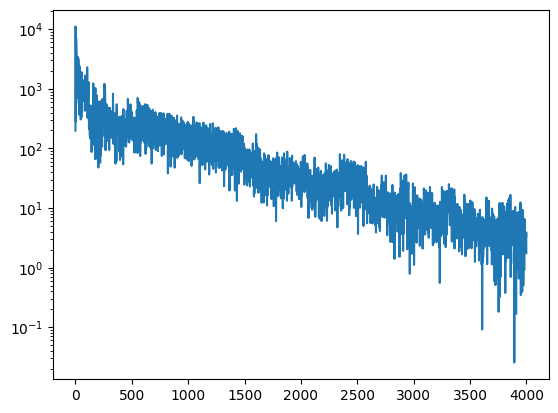

In [32]:
plt.plot(model.losses)
plt.yscale('log')

In [33]:
X_re, X_mask, Y_re, Y_mask, _, _ = get_restructured_data(df, preds, targets, 'id')
print(X_re.shape)
print(Y_re.shape)
print(Y_mask.shape)

torch.Size([3, 3000, 2])
torch.Size([3, 3000, 1])
torch.Size([3, 3000])


In [34]:
probs = model.classify(X_re, Y_real=Y_re, Y_real_mask=Y_mask)

In [35]:
print(probs)

tensor([[0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        ...,
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.]])


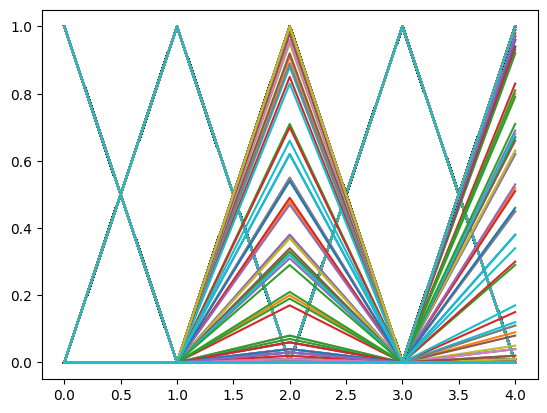

In [36]:
plt.plot(probs.T);

Overlap trajectories with data to inspect fit:

In [37]:
np.sum(probs.numpy(),0)

array([600.  , 600.  , 467.33, 600.  , 732.67])

In [38]:
np.argmax(probs.numpy(), axis=1)

array([1, 1, 1, ..., 0, 0, 0])

In [39]:
df['traj_gt']

0       1
1       1
2       1
3       1
4       1
       ..
8995    5
8996    5
8997    5
8998    5
8999    5
Name: traj_gt, Length: 9000, dtype: int64

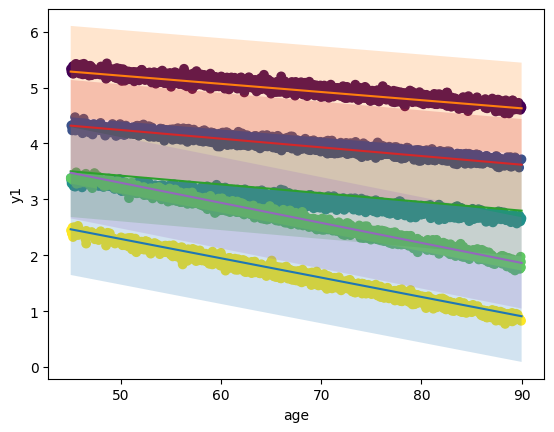

In [40]:
plt.close('all')


plt.scatter(df['age'], df['y1'], c=df['traj_gt'])
#plt.scatter(df['age'], df['y1'], c=np.argmax(probs.numpy(), axis=1))
plt.xlabel('age')
plt.ylabel('y1')

K = 5
X = torch.ones([100, 2])
X[:, 1] = torch.linspace(45, 90, 100)
for kk in range(K):
    w = model.params['params']['AutoNormal.locs.W_'][kk, 0].data.numpy()
    lambda_ = model.params['params']['AutoNormal.locs.lambda_'][kk].data
    stddev = lambda_.rsqrt().numpy()
    y1_tmp = np.dot(X.numpy(), w.T)
    plt.plot(X[:, 1], y1_tmp)
    lb = y1_tmp - 2*stddev
    ub = y1_tmp + 2*stddev
    plt.fill_between(X[:, 1], lb, ub, alpha=0.2)
plt.show()

In [ ]:
q